# Assignment 1

**Group 22**

A. Siganos ( 1283871 )     
J. Gómez Robles ( 1286552 )

In [1]:
import numpy as np
np.random.seed(13) #TODO Check if this is used for sgd
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Reshape, Lambda
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import model_to_dot
from keras.preprocessing import sequence
from gensim.models import KeyedVectors
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors as nn
from matplotlib import pylab
from __future__ import division

# To measure running times
import time

#from matplotlib import pyplot
#%matplotlib notebook
import matplotlib.pyplot as plt

# For 2d mapping
import operator

# Only for the word2vec parsing of last exercise (loading word2vec with gensim was part of the initial template)
import gensim


Using TensorFlow backend.


In [2]:
# DO NOT Modify the lines in this cell
path = 'alice.txt'
corpus = open(path).readlines()[0:700]

corpus = [sentence for sentence in corpus if sentence.count(" ") >= 2]

tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'+"'")
tokenizer.fit_on_texts(corpus)
corpus = tokenizer.texts_to_sequences(corpus)
nb_samples = sum(len(s) for s in corpus)
V = len(tokenizer.word_index) + 1

# Is this something they need to change?
dim = 100
window_size = 2 #use this window size for Skipgram, CBOW, and the model with the additional hidden layer
window_size_corpus = 4 #use this window size for the co-occurrence matrix


In [379]:
# Get my index
full_index = tokenizer.word_index

# Get labels 
def getLabels(index, includeZero = False):
    sorted_labels = sorted(index.items(), key=operator.itemgetter(1))
    if includeZero :
        sorted_labels.insert(0, ('', 0))
    labels_only = [i[0] for i in sorted_labels]
    return np.asarray(labels_only)

def getAnalogyWords():
    content = []
    with open("analogy_alice.txt") as f:
        content = f.readlines()

    # Remove whitespace characters like '\n' at the end of each line
    content = [x.strip() for x in content] 
    wordsSubset = []
    
    for analogy in content:
        words = analogy.split(" ")
        if len(words) == 4:
            wordsSubset.append(words[0])
            wordsSubset.append(words[1])
            wordsSubset.append(words[2])
            wordsSubset.append(words[3])
    return wordsSubset
# 
CO_OCURRENCE_FILE = "co-ocurrence.txt"

def saveToWord2VecFormat(fileName, vectors, size, lastIndex = True): 
    V = size
    if not lastIndex :
        V -= 1
    
    f = open(fileName , "w")
    f.write(" ".join([str(V),str(V)]))
    f.write("\n")
    for word, i in tokenizer.word_index.items():    
        f.write(word)
        f.write(" ")
        f.write(" ".join(map(str, list(vectors[i,:V]))))
        f.write("\n")
    f.close()



In [411]:
################################################################################
############################## 0. Util functions ###############################
################################################################################

# Run this block first
def getKeyFromValue(dictionary, target):
    return list(dictionary.keys())[list(dictionary.values()).index(target)]

# Visualization function
def plot_embedding(x, labels, labelsIntersect, title):
    x0Max = max(x[:, 0])
    x1Max = max(x[:, 1])
    x0Min = min(x[:, 0])
    x1Min = min(x[:, 1])

    x1Size = x1Max - x1Min
    x0Size = x0Max - x0Min
    
    fig,ax = plt.subplots()
    fig.set_size_inches((x0Size/x1Size)*15, 15)
    plt.title(title, fontsize=20)
    plt.scatter(x[:,0], x[:,1], s = 5)
    
    for i in range(len(labels)):
        if( labels[i] in labelsIntersect):
            plt.annotate(labels[i],
                     xy=(x[i,0], x[i,1]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()


## Question 1

### Co-occurrence Matrix
Use the provided code to load the "Alice in Wonderland" text document. 
1. Implement the word-word co-occurrence matrix for “Alice in Wonderland”
2. Normalize the words such that every value lies within a range of 0 and 1
3. Compute the cosine distance between the given words:
    - Alice 
    - Dinah
    - Rabbit
4. List the 5 closest words to 'Alice'. Discuss the results.
5. Discuss what the main drawbacks are of a term-term co-occurence matrix solutions?


numpy.float32

In [35]:
################################################################################
################# 1. Implement word-word co-ocurrence matrix ###################
################################################################################

# Create my co-ocurrence matrix, initially 0 (VxV size)
# How to access this matrix:
#   Each column is an (index - 1) (column 0 is word in index 1; column 1 is word in index 2; ...)
wcoMatrix = np.zeros([V, V]) 

# Using my window_size_corpus to define my context scope
scope = window_size_corpus

# TODO: Do not make that many iterations
# Greedy approach first (to be able to compare the optimization)

# For each line in the corpus. Note that they preserve the order, even when they are indexes now.
for s in corpus:
    # For each word
    for current_index in range(0, len(s)):
        current_value = s[current_index] # Get the 'word'
        # From left to right
        for neighbor_index in range(current_index - scope, current_index + scope + 1):
            # Never out of boundaries and never the same index
            if ( neighbor_index >= 0 and neighbor_index < len(s) ) and ( neighbor_index != current_index ):
                # Get my neighbor 'word'
                neighbor = s[neighbor_index] 
                # Never myself and myself (keeping diagonal to 0)
                if current_value != neighbor:
                    # Update the ocurrence
                    #wcoMatrix[current_value - 1, neighbor - 1] += 1
                    wcoMatrix[current_value, neighbor] += 1
                    
################################################################################
################################# 2. Normalize #################################
################################################################################
wcoMatrix = wcoMatrix / wcoMatrix.max()
wcoMatrix

# saveToWord2VecFormat(CO_OCURRENCE_FILE, wcoMatrix, V, False)

print("Sumary of the word-word co-ocurrence matrix")
print(" - Shape", wcoMatrix.shape)
print(" - Min value", wcoMatrix.min())
print(" - Max value", wcoMatrix.max())


Sumary of the word-word co-ocurrence matrix
 - Shape (1183, 1183)
 - Min value 0.0
 - Max value 1.0


In [36]:
################################################################################
########### 3. Compute cosine similarity to Alice, Dinah and Rabbit ############
################################################################################

words_to_compare = ["Alice", "Dinah", "Rabbit"]

wcoMatrix

# Iterate on all possible combinations
for w1 in words_to_compare:
    w1 = w1.lower() 
    x = full_index[w1]
    for w2 in words_to_compare:
        w2 = w2.lower()
        if w1 != w2:
            y = full_index[w2]
            X = wcoMatrix[x, :].reshape((1, V))
            Y = wcoMatrix[y, :].reshape((1, V))
            print("cosine_similarity(%s, %s)=%s" % (w1, w2, cosine_similarity(X, Y)))
            

cosine_similarity(alice, dinah)=[[0.39360011]]
cosine_similarity(alice, rabbit)=[[0.47890931]]
cosine_similarity(dinah, alice)=[[0.39360011]]
cosine_similarity(dinah, rabbit)=[[0.29862324]]
cosine_similarity(rabbit, alice)=[[0.47890931]]
cosine_similarity(rabbit, dinah)=[[0.29862324]]


In [7]:
################################################################################
################## 4a. List the 5 closest words to 'Alice'. ####################
################################################################################

################################
### We use Nearest Neighbors ###
################################

# It was not importing
from sklearn.neighbors import NearestNeighbors

# Define our variables
targetWord = "Alice".lower()
X = wcoMatrix
N_NEIGHBORS = 5
full_index = tokenizer.word_index

# Perfrom the NearestNeibhbors algorithm
# TODO: Tune parameters
nbrs = NearestNeighbors(n_neighbors = N_NEIGHBORS).fit(X)

# Get the index corresponding to the target word
aliceMatrixIndex = full_index[targetWord]

# Get results from nearest neighbors
distances, indices = nbrs.kneighbors()
aliceIndices = indices[aliceMatrixIndex, :]
aliceDistances = distances[aliceMatrixIndex, :]

# Output result
print("Nearest neighbors (co-ocurrence matrix based) to %s (index %s):" % (targetWord, aliceMatrixIndex))
for i in range(0, N_NEIGHBORS):
    print( "%s [index %s] with distance: %s" % (getKeyFromValue(full_index, aliceIndices[i]), aliceIndices[i], aliceDistances[i]) )

# TODO: Think about what we are computing. 
# With first approach, a neighbor would be a word with a similar vector in the co-ocurrence matrix, 
# not a word within the same context (window_size). Although words in the similar window_size should have a
# similar vector, isn't?

Nearest neighbors (co-ocurrence matrix based) to alice (index 11):
her [index 14] with distance: 0.5616433150108668
that [index 13] with distance: 0.5692975698101006
herself [index 41] with distance: 0.5700573426956416
for [index 18] with distance: 0.5811858638252018
on [index 21] with distance: 0.5837124477057559


**4b. Discuss the results**

We observe that the most similar words are possesives and prepositions. Although these results intuitively make some sense (Alice is the main character of the book and consequently, describing her behaviour is expected), no idiomatic relations can be achieved by means of the simple word-word co-ocurrence matrix.

Furthermore, the minimal distance (cosine similarity normalized) found for alice is of 0.5616, which suggests a poor result - one would be interested on a similarity close to 0.


**5. Discuss what the main drawbacks are of a term-term co-occurence matrix solutions? **

A co-occurence matrix  requires large memory for storage especially for larger data sets. A co-occurence matrix also has the negative of losing the "polysemantic" words. For example if inside our corpus there is such a word, lets say "jaguar" with both meanings, that is the car brand and the animal. 


In [26]:
# reopen your file as follows
# TODO: Check! It is not reloading the file D:
#co_occurrence = KeyedVectors.load_word2vec_format('./vectors_co_occurrence.txt', binary=False)


## Question 2

### Word embeddings
Build embeddings with a keras implementation where the embedding vector is of length 50, 150 and 300. Use the Alice in Wonderland text book for training.
1. Using the CBOW model
2. Using Skipgram model
3. Add extra hidden dense layer to CBow and Skipgram implementations. Choose an activation function for that layer and justify your answer.
4. Analyze the four different word embeddings
    - Implement your own function to perform the analogy task with. Do not use existing libraries for this task such as Gensim. Your function should be able to answer whether an anaology as in the example given in the pdf-file is true.
    - Compare the performance on the analogy task between the word embeddings that you have trained in 2.1, 2.2 and 2.3.  
    - Visualize your results and interpret your results
5. Use the word co-occurence matrix from Question 1. Compare the performance on the analogy task with the performance of your trained word embeddings.  
6. Discuss:
    - What are the main advantages of CBOW and Skipgram?
    - What is the advantage of negative sampling?
    - What are the main drawbacks of CBOW and Skipgram?
7. Load pre-trained embeddings on large corpuses (see the pdf file). You only have to consider the word embeddings with an embedding size of 300
    - Compare performance on the analogy task with your own trained embeddings from "Alice in Wonderland". You can limit yourself to the vocabulary of Alice in Wonderland. Visualize the pre-trained word embeddings and compare these with the results of your own trained word embeddings. 


# CBOW

In [57]:
# prepare data for cbow
def generate_data_cbow(corpus, window_size, V):
    all_in = [] 
    all_out = []
    maxlen = window_size*2
    for words in corpus:
        L = len(words)
        for index, word in enumerate(words):
            contexts = []
            labels   = []            
            s = index - window_size
            e = index + window_size + 1
            
            contexts.append([words[i] for i in range(s, e) if 0 <= i < L and i != index])
            labels.append(word)
            if contexts != []:
                all_in.append(sequence.pad_sequences(contexts, maxlen = maxlen))
                all_out.append(np_utils.to_categorical(labels, V))
    return (all_in,all_out) # return the values
            

In [180]:
#create CBOW model

def getCbowModel(dim = 50, extra_layer = False):

    # The Sequential model is a linear stack of layers.
    cbow = Sequential()
    cbow.add(Embedding(input_dim = V, output_dim = dim, input_length = window_size*2))

    if extra_layer :
        cbow.add(Dense(input_dim = V, units = dim, kernel_initializer = 'uniform', activation = 'relu'))
#        cbow.add(Activation(lambda x: K.relu(x, alpha = 0)))

    # input_dim=V input ,units=dim output
    cbow.add( Lambda(lambda x: K.mean(x, axis = 1), output_shape = (dim,)) )
    cbow.add( Dense(V, activation = 'softmax') )

    # define loss function for Cbow
    cbow.compile(loss='categorical_crossentropy', optimizer = 'sgd')

    return cbow



In [173]:
#train model

################################################################################
############################ 1. Using CBOW model ###############################
################################################################################

dims = [50, 150, 300]
#dims = [50]
iterations = 10
cbowWeights = []

for dimension in dims:
    print("Running CBOW (dim = %s)..."% dimension)
    cbow = getCbowModel(dimension, False)
    X, Y = generate_data_cbow(corpus, window_size, V)
    start_time=time.time()
    for ite in range(iterations):
        loss = 0.
        for x, y in zip(X, Y):
            loss += cbow.train_on_batch(x, y)
        print(ite, loss)

    end_time = time.time()
    
    print("--- %s seconds ---" % (end_time - start_time))
    
    cbowWeights.append(cbow.get_weights()[0])


Running CBOW (dim = 50)...
0 41689.10064268112
1 39125.26202464104
2 38923.00615680218
3 38836.63505420089
4 38790.464297086
5 38739.01745219529
6 38674.78940945864
7 38612.284679576755
8 38567.22870832682
9 38541.5636402145
--- 121.01353883743286 seconds ---
Running CBOW (dim = 150)...
0 41628.13011813164
1 38775.51617372036
2 38364.221499979496
3 38133.25300589204
4 37919.876286149025
5 37727.89859366417
6 37550.81310313195
7 37398.434321200475
8 37277.52128098998
9 37180.624406711664
--- 312.51593375205994 seconds ---
Running CBOW (dim = 300)...
0 41555.26018857956
1 38485.71672564745
2 37953.73395010829
3 37635.21111321449
4 37344.110524103045
5 37089.64993582666
6 36879.38917183317
7 36708.74810144212
8 36566.21229555225
9 36440.37129682442
--- 691.8513219356537 seconds ---


# Skipgram

In [37]:
#prepare data for Skipgram

# This function creates a list where _each word_ in the text file (with non-empty content)
# is encoded into two arrays:
#   - x: an array of the size of all his windows_size neighbors with the value of the word (i.e, repeated values)
#   - y: an array of the same size as x pointing to each neighbor. Finally encoded in a |V|-list as one-hot enc
def generate_data_skipgram(corpus, window_size, V):
    all_in = [] 
    all_out = []
    for sentence in corpus: # For, sentence in corpus
        L = len(sentence) # Limit for the iteration (per sentence)

        # For each pair in the index
        for index, word in enumerate(sentence):
            # Create X and Y
            in_words = [] # list of lists
            labels = [] # list of integers

            # Iterate over all the sentence, for each word in the line. I.e, for each word:
            for i in range(index - window_size, index + window_size + 1):
                # If between the limits and not myself
                if i != index and (0 <= i < L):
                    # This means: Associating the words in my neighbor (context) 
                    in_words.append([word]) # Current word (as a list) is associated to...
                    labels.append(sentence[i]) # ... this word (as a simple integer).
                    
            # Once I have saved the context for the current word...
            # ... if there is something in the arrays
            if in_words != []:
                # Save the information to the all_in/out arrays
                all_in.append(np.array(in_words,dtype=np.int32)) # X in integer format
                # Set Y to categorical values. If my output is ([6, 26]). Then I create
                # a vector from 0 to V and mark 6 and 26 as 1
                all_out.append(np_utils.to_categorical(labels, V))
    return (all_in,all_out) # return the values



In [396]:
len(generate_data_skipgram(corpus, window_size, V)[1])

6546

In [38]:
# create Skipgram model
import tensorflow as tf
from keras.layers import Activation

def getSkipgramModel(dim = 50, extra_layer = False):

    # The Sequential model is a linear stack of layers.
    skipgram = Sequential()
    
    # First layer (Projection layer. Embedding for wt)
    # 
    # Parameters: 
    #   - input_dim: V (From the book: 1xV (input layer))
    #   - embeddings_initializer = Glorot uniform. Is it for the uniform distribution of the noises?
    #   - input_length: 1. It is needed for the dense layer (https://keras.io/layers/embeddings/#embedding)
    # Input: One-hot ecoding of word wt in the 1xV space
    # Output: vj in the dimension space 1xd
    skipgram.add( Embedding(input_dim = V, output_dim = dim, embeddings_initializer = 'glorot_uniform', input_length = 1) )

    # Intermediate layer. Can be seen as a helper only.
    skipgram.add( Reshape((dim, )) )

    
    # Extra layer
    #
    # Justification: 
    #
    #
    if extra_layer :
        skipgram.add(Dense(input_dim = dim, units = V, kernel_initializer = 'uniform', activation = "relu"))

    # Last Layer (Output layer. Probabilities of context words)
    # From documentation, Dense implements the operation: 
    #      output = activation(dot(input, kernel) + bias) 
    #   where:
    #      activation is the element-wise activation function passed as the activation argument
    #      kernel is a weights matrix created by the layer
    #      and bias is a bias vector created by the layer (only applicable if use_bias is True). _WE DO NOT SET THIS_.
    #
    # Hence, we are computing ck*vj
    #
    # Parameters:
    #   - input_dim: dim. From embedding layer, dx1
    #   - units: V. The output dimension, From the book 1xV
    #   - kernel_initializer: uniform (?)
    #   - activation: softmax (as described in the book)

    skipgram.add( Dense(input_dim = dim, units = V, kernel_initializer = 'uniform', activation = 'softmax') )
    
    
    # define loss function for Skipgram
    skipgram.compile(loss='categorical_crossentropy', optimizer='sgd')

    return skipgram

In [332]:
################################################################################
########################## 2. Using Skipgram model #############################
################################################################################

dims = [50, 150, 300]
iterations = 10
skipgramWeights = []

for dimension in dims:
    print("Running Skipgram (dim = %s)..."% dimension)
    skipgram = getSkipgramModel(dimension, False)
    #print(skipgram.summary())
    X, Y = generate_data_skipgram(corpus, window_size, V)

    start_time = time.time()
    for ite in range(iterations):
        loss = 0.
        for x, y in zip(X,Y):
            loss += skipgram.train_on_batch(x, y)
        print(ite, loss)
    end_time = time.time()
    
    print("--- %s seconds ---" % (end_time - start_time))
    
    skipgramWeights.append(skipgram.get_weights()[0])


Running Skipgram (dim = 50)...
0 41272.99892401695
1 39108.59423494339
2 39263.53147101402
3 39344.446774959564
4 39418.84771478176
5 39503.74409818649
6 39604.75497293472
7 39722.0500357151
8 39851.04646277428
9 39988.060670256615
--- 215.43067693710327 seconds ---
Running Skipgram (dim = 150)...
0 41221.8186609745
1 38931.67290854454
2 38990.37560772896
3 39008.111822366714
4 39038.9247815609
5 39086.154546260834
6 39145.19317615032
7 39206.06193840504
8 39258.26997470856
9 39295.91516304016
--- 410.2476942539215 seconds ---
Running Skipgram (dim = 300)...
0 41154.81443333626
1 38741.40790605545
2 38716.1145619154
3 38670.04332411289
4 38637.544976472855
5 38615.08951258659
6 38586.223935723305
7 38542.783294677734
8 38490.78570437431
9 38441.46473324299
--- 759.6460092067719 seconds ---


# Justification of additional layer


# CBOW additional hidden layer

In [183]:
################################################################################
##################### 3. Using CBOW model (extra layer) ########################
################################################################################

dims = [50, 150, 300]
# dims = [50]
iterations = 7
cbowHiddenLayerWeights = []

for dimension in dims:
    print("Running CBOW with hidden layer (dim = %s)..."% (dimension))
    cbow = getCbowModel(dimension, True)
    X, Y = generate_data_cbow(corpus, window_size, V)

    start_time = time.time()
    for ite in range(iterations):
        loss = 0.
        for x, y in zip(X,Y):
            loss += cbow.train_on_batch(x, y)
        print(ite, loss)
    end_time = time.time()

    print("--- %s seconds ---" % (end_time - start_time))

    cbowHiddenLayerWeights.append(cbow.get_weights()[0])


Running CBOW with hidden layer (dim = 50)...
0 42835.205963373184
1 38521.03821849823
2 38200.11601948738
3 38113.16721010208
4 38057.447900772095
5 38004.40702652931
6 37940.61535048485
--- 75.95321798324585 seconds ---
Running CBOW with hidden layer (dim = 150)...
0 42143.233686208725
1 38433.93616986275
2 38180.78026199341
3 38085.532644987106
4 38001.45462465286
5 37900.84845781326
6 37774.598672032356
--- 122.40742015838623 seconds ---
Running CBOW with hidden layer (dim = 300)...
0 41760.01046895981
1 38391.64880633354
2 38156.602551698685
3 38044.440955638885
4 37928.15160560608
5 37780.81008219719
6 37604.70224964619
--- 241.64078521728516 seconds ---


# Skipgram additional hidden layer

In [333]:
################################################################################
################### 3. Using Skipgram model (extra layer) ######################
################################################################################

dims = [50, 150, 300]
#dims = [50]
iterations = 3
skipgramHiddenLayerWeights = []

for dimension in dims:
    print("Running Skipgram with hidden layer (dim = %s)..."% (dimension))
    # set extra_layer = true
    skipgram = getSkipgramModel(dimension, True)
    X, Y = generate_data_skipgram(corpus, window_size, V)

    start_time = time.time()
    for ite in range(iterations):
        loss = 0.
        for x, y in zip(X,Y):
            loss += skipgram.train_on_batch(x, y)
        print(ite, loss)
    end_time = time.time()

    print("--- %s seconds ---" % (end_time - start_time))
    skipgramHiddenLayerWeights.append(skipgram.get_weights()[0])



Running Skipgram with hidden layer (dim = 50)...
0 38284.46276092529
1 37632.44427061081
2 37268.5751568079
--- 542.6126079559326 seconds ---
Running Skipgram with hidden layer (dim = 150)...
0 38210.91470813751
1 37408.42973637581
2 37064.799334168434
--- 637.7531459331512 seconds ---
Running Skipgram with hidden layer (dim = 300)...
0 38257.76077961922
1 37454.10696053505
2 36982.87641811371
--- 727.2763850688934 seconds ---


In [325]:
################################################################################
####### 4a. Implement your own function to perform the analogy task with #######
################################################################################

EMBEDDING_TYPE_1 = "weightedMatrix"
EMBEDDING_TYPE_2 = "word2vec"

#from gensim import matutils  # utility fnc for pickling, common scipy operations etc
#from numpy import dot
import math

# neighbors is the NearestNeighbor object containing the computed neighbors matrix
# objA is to objB as objC is a objD
# we assume objs are strings
def analogyFunction(neighbors, index, objA, objB, objC, objD, embeddingType = EMBEDDING_TYPE_1, matrix = wcoMatrix):
    
    if embeddingType != EMBEDDING_TYPE_2:
        indexA = index[objA]
        indexB = index[objB]
        indexC = index[objC]
        indexD = index[objD]
        vecA = np.asarray(matrix[indexA,])
        vecB = np.asarray(matrix[indexB,])
        vecC = np.asarray(matrix[indexC,])
        vecD = np.asarray(matrix[indexD,])
    
    if embeddingType == EMBEDDING_TYPE_2 :
        vecA = index.get_vector(objA)
        vecB = index.get_vector(objB)
        vecC = index.get_vector(objC)
        vecD = index.get_vector(objD)
    # woman is a queen - man is a king
    #   A          B      C         D
    #         >>> trained_model.most_similar(positive=['woman', 'king'], negative=['man'])


# #    operationResult = vecA - vecB + vecD
#     operationResult = vecA - vecB + vecD
# if embeddingType == EMBEDDING_TYPE_2 :
#     mean = []
#     mean.append(4.0*vecA)
#     mean.append(4.0*vecD)
#     mean.append(-2.0*vecC)
#     mean = np.array(mean).mean(axis=0)
# else :
    mean = (1.0*vecA) - (1.0*vecC) + (1.0*vecD)
        
    # Otherwise, get the nearest neighbor of the resulting vector
    if embeddingType == EMBEDDING_TYPE_2 : # For google and glove, respect the space, otherwise it does not make sense
        finalWord = index.similar_by_vector(mean, 1)[0][0]
    else:
        distances, indices = neighbors.kneighbors([mean])
        neighborIndex = indices[0, 0]
        if neighborIndex == 0:
            return False, "None"
        finalWord = getKeyFromValue(index, neighborIndex)

    outputString = "(word, prediction) = (" + objB + ", " + finalWord + ")" 
    # Return comparison of words
    return ( objB == finalWord ), outputString


def makeAnalogyOnFile(neighbors, embeddingType = EMBEDDING_TYPE_1, matrix = wcoMatrix, index = full_index):
    # Read file
    content = []
    with open("analogy_alice.txt") as f:
        content = f.readlines()

    # Remove whitespace characters like '\n' at the end of each line
    content = [x.strip() for x in content] 
    allResults = []
    
    for analogy in content:
        words = analogy.split(" ")
        if len(words) == 4:
            try:
                result, resultString = analogyFunction(neighbors, index, words[0], words[1], words[2], words[3], embeddingType, matrix)
                allResults.append(result)
                print("[%s] '%s' - %s" % (result, analogy, resultString))
            except KeyError:
                pass
    return allResults


Comparison performance:

In [326]:
################################################################################
########### 4b. Compare the performance on the analogy task between ############
########### the word embeddings you have trained in 2.1, 2.2 & 2.3  ############
################################################################################

weights = skipgramWeights[len(skipgramWeights) - 1] # Always plot the last one
nbrs = NearestNeighbors(n_neighbors = 1).fit(weights)
analogyResults = makeAnalogyOnFile(nbrs, EMBEDDING_TYPE_1, weights, full_index)
print("\nCount for Skipgram embedding: %s" % (sum(analogyResults)))
print("Score for Skipgram embedding: %s" % (sum(analogyResults)/len(analogyResults)))



[False] 'sudden suddenly usual usually' - (word, prediction) = (suddenly, sudden)
[False] 'bad worse good better' - (word, prediction) = (worse, better)
[False] 'go going look looking' - (word, prediction) = (going, go)
[False] 'he she his her' - (word, prediction) = (she, her)
[False] 'brother sister his her' - (word, prediction) = (sister, her)
[False] 'listen listening look looking' - (word, prediction) = (listening, looking)
[False] 'saying said thinking thought' - (word, prediction) = (said, thought)
[False] 'bird birds cat cats' - (word, prediction) = (birds, cats)
[False] 'good better old older' - (word, prediction) = (better, good)
[False] 'good better quick quicker' - (word, prediction) = (better, good)
[False] 'large largest good best' - (word, prediction) = (largest, best)
[False] 'falling fell knowing knew' - (word, prediction) = (fell, before)
[False] 'walk walking think thinking' - (word, prediction) = (walking, walk)
[False] 'child children cat cats' - (word, prediction)

In [327]:

weights = cbowWeights[len(cbowWeights) - 1] # Always plot the last one
nbrs = NearestNeighbors(n_neighbors = 1).fit(weights)
analogyResults = makeAnalogyOnFile(nbrs, EMBEDDING_TYPE_1, weights, full_index)

print("\nCount for cbow embedding: %s" % (sum(analogyResults)))
print("Score for cbow embedding: %s" % (sum(analogyResults)/len(analogyResults)))


[False] 'sudden suddenly usual usually' - (word, prediction) = (suddenly, sudden)
[False] 'bad worse good better' - (word, prediction) = (worse, better)
[False] 'go going look looking' - (word, prediction) = (going, go)
[False] 'he she his her' - (word, prediction) = (she, her)
[False] 'brother sister his her' - (word, prediction) = (sister, her)
[False] 'listen listening look looking' - (word, prediction) = (listening, listen)
[False] 'saying said thinking thought' - (word, prediction) = (said, thought)
[False] 'bird birds cat cats' - (word, prediction) = (birds, cats)
[False] 'good better old older' - (word, prediction) = (better, good)
[False] 'good better quick quicker' - (word, prediction) = (better, good)
[False] 'large largest good best' - (word, prediction) = (largest, large)
[False] 'falling fell knowing knew' - (word, prediction) = (fell, knew)
[False] 'walk walking think thinking' - (word, prediction) = (walking, walk)
[False] 'child children cat cats' - (word, prediction) =

In [328]:
weights = skipgramHiddenLayerWeights[len(skipgramHiddenLayerWeights) - 1]
# tsne = TSNE(n_components=2, verbose=1)
# transformed_weights = tsne.fit_transform(weights)

nbrs = NearestNeighbors(n_neighbors = 1).fit(weights)
analogyResults = makeAnalogyOnFile(nbrs, EMBEDDING_TYPE_1, weights, full_index)
print("\nCount for skipgram (extra hideen layer) embedding: %s" % (sum(analogyResults)))
print("Score for skipgram (extra hideen layer) embedding: %s" % (sum(analogyResults)/len(analogyResults)))


[False] 'sudden suddenly usual usually' - (word, prediction) = (suddenly, usually)
[False] 'bad worse good better' - (word, prediction) = (worse, bad)
[False] 'go going look looking' - (word, prediction) = (going, go)
[False] 'he she his her' - (word, prediction) = (she, her)
[False] 'brother sister his her' - (word, prediction) = (sister, her)
[False] 'listen listening look looking' - (word, prediction) = (listening, listen)
[False] 'saying said thinking thought' - (word, prediction) = (said, saying)
[False] 'bird birds cat cats' - (word, prediction) = (birds, bird)
[False] 'good better old older' - (word, prediction) = (better, older)
[False] 'good better quick quicker' - (word, prediction) = (better, quicker)
[False] 'large largest good best' - (word, prediction) = (largest, best)
[False] 'falling fell knowing knew' - (word, prediction) = (fell, falling)
[False] 'walk walking think thinking' - (word, prediction) = (walking, thinking)
[False] 'child children cat cats' - (word, predic

In [329]:
weights = cbowHiddenLayerWeights[len(cbowHiddenLayerWeights) - 1]
nbrs = NearestNeighbors(n_neighbors = 1).fit(weights)
analogyResults = makeAnalogyOnFile(nbrs, EMBEDDING_TYPE_1, weights, full_index)
print("\nCount for cbow (extra hideen layer) embedding: %s" % (sum(analogyResults)))
print("Score for cbow (extra hideen layer) embedding: %s" % (sum(analogyResults)/len(analogyResults)))


[False] 'sudden suddenly usual usually' - (word, prediction) = (suddenly, sudden)
[False] 'bad worse good better' - (word, prediction) = (worse, better)
[False] 'go going look looking' - (word, prediction) = (going, looking)
[False] 'he she his her' - (word, prediction) = (she, her)
[False] 'brother sister his her' - (word, prediction) = (sister, her)
[False] 'listen listening look looking' - (word, prediction) = (listening, looking)
[False] 'saying said thinking thought' - (word, prediction) = (said, thought)
[False] 'bird birds cat cats' - (word, prediction) = (birds, cats)
[False] 'good better old older' - (word, prediction) = (better, good)
[False] 'good better quick quicker' - (word, prediction) = (better, good)
[False] 'large largest good best' - (word, prediction) = (largest, large)
[False] 'falling fell knowing knew' - (word, prediction) = (fell, falling)
[False] 'walk walking think thinking' - (word, prediction) = (walking, walk)
[False] 'child children cat cats' - (word, pred

1183

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1183 samples in 0.007s...
[t-SNE] Computed neighbors for 1183 samples in 0.757s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1183
[t-SNE] Computed conditional probabilities for sample 1183 / 1183
[t-SNE] Mean sigma: 0.148625
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.357376
[t-SNE] Error after 1000 iterations: 1.910123


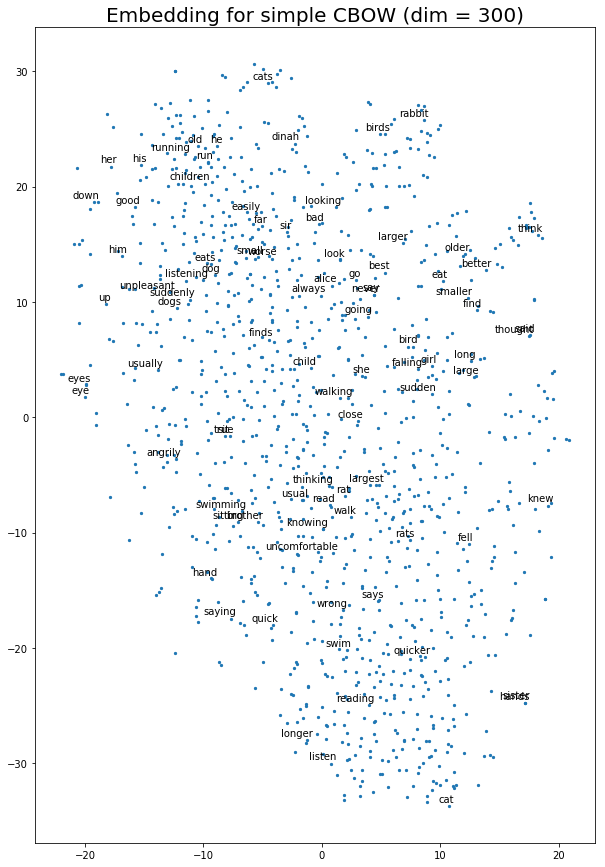

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1183 samples in 0.008s...
[t-SNE] Computed neighbors for 1183 samples in 0.734s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1183
[t-SNE] Computed conditional probabilities for sample 1183 / 1183
[t-SNE] Mean sigma: 0.142888
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.880165
[t-SNE] Error after 1000 iterations: 2.848763


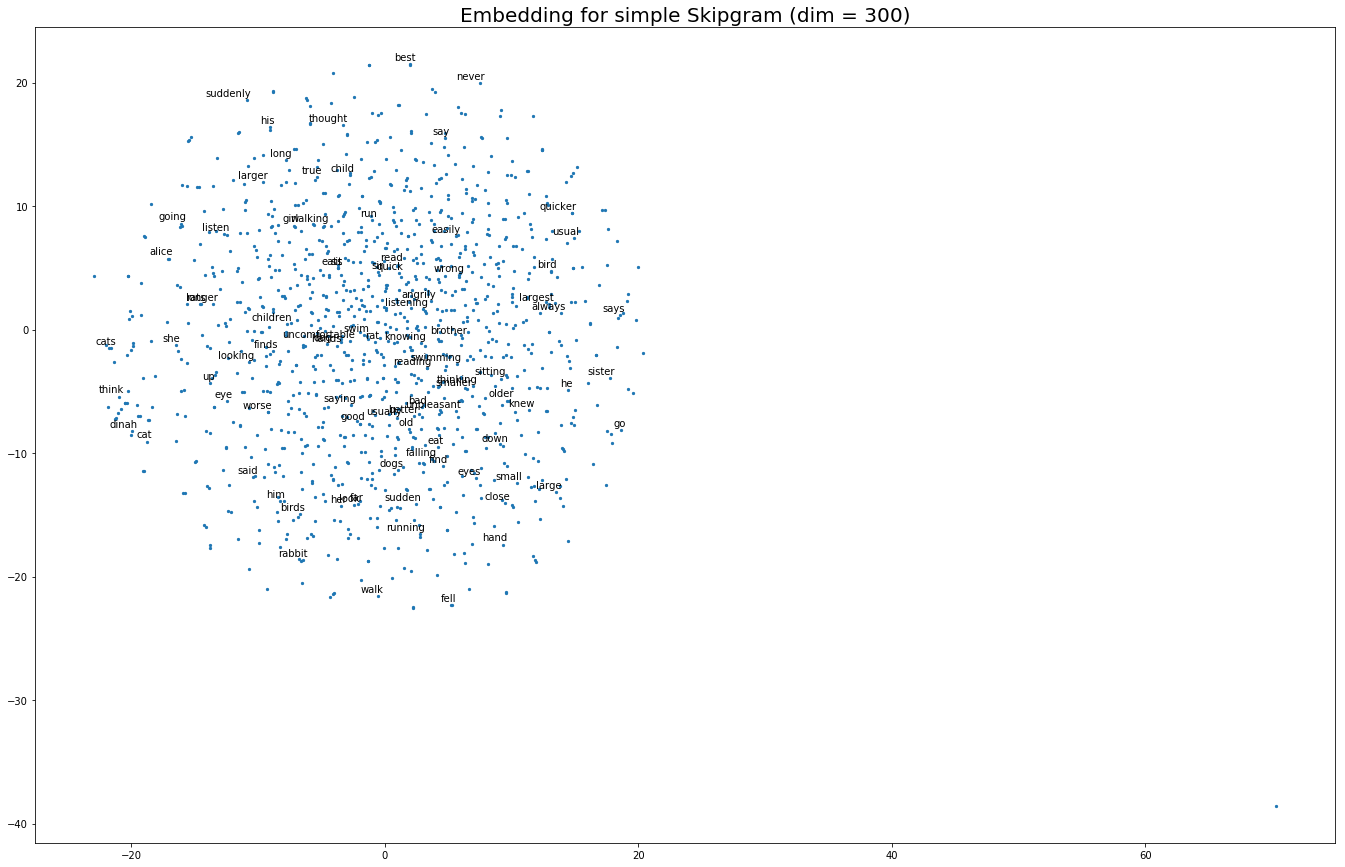

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1183 samples in 0.009s...
[t-SNE] Computed neighbors for 1183 samples in 0.863s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1183
[t-SNE] Computed conditional probabilities for sample 1183 / 1183
[t-SNE] Mean sigma: 0.103838
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.647438
[t-SNE] Error after 1000 iterations: 2.942775


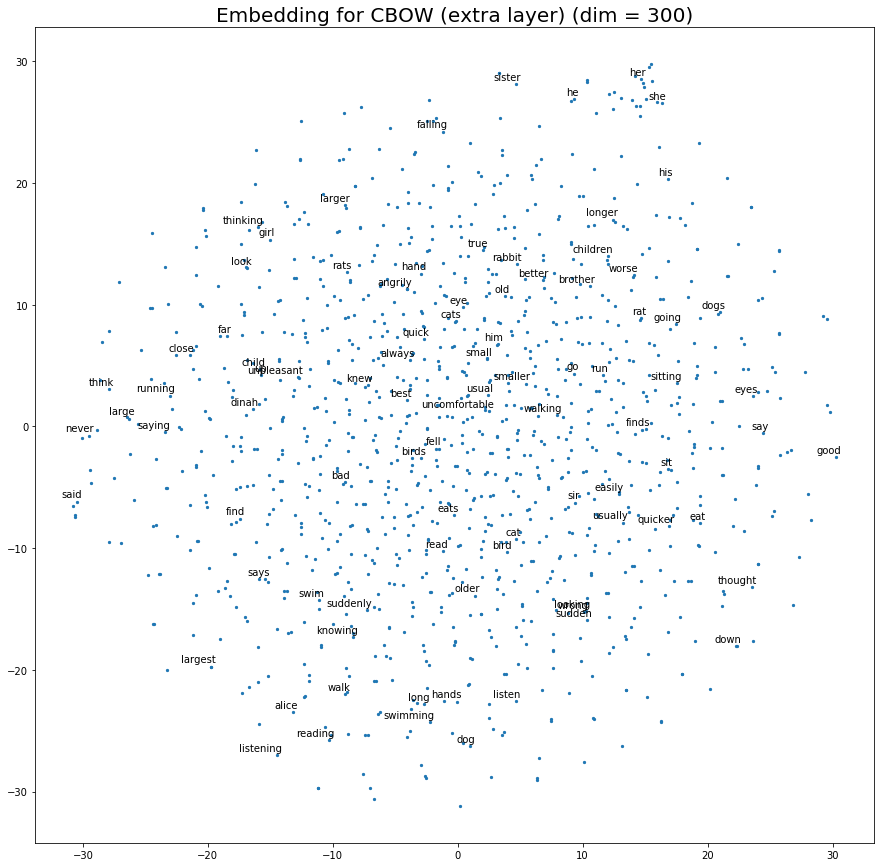

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1183 samples in 0.008s...
[t-SNE] Computed neighbors for 1183 samples in 0.773s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1183
[t-SNE] Computed conditional probabilities for sample 1183 / 1183
[t-SNE] Mean sigma: 0.133932
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.461388
[t-SNE] Error after 1000 iterations: 3.009172


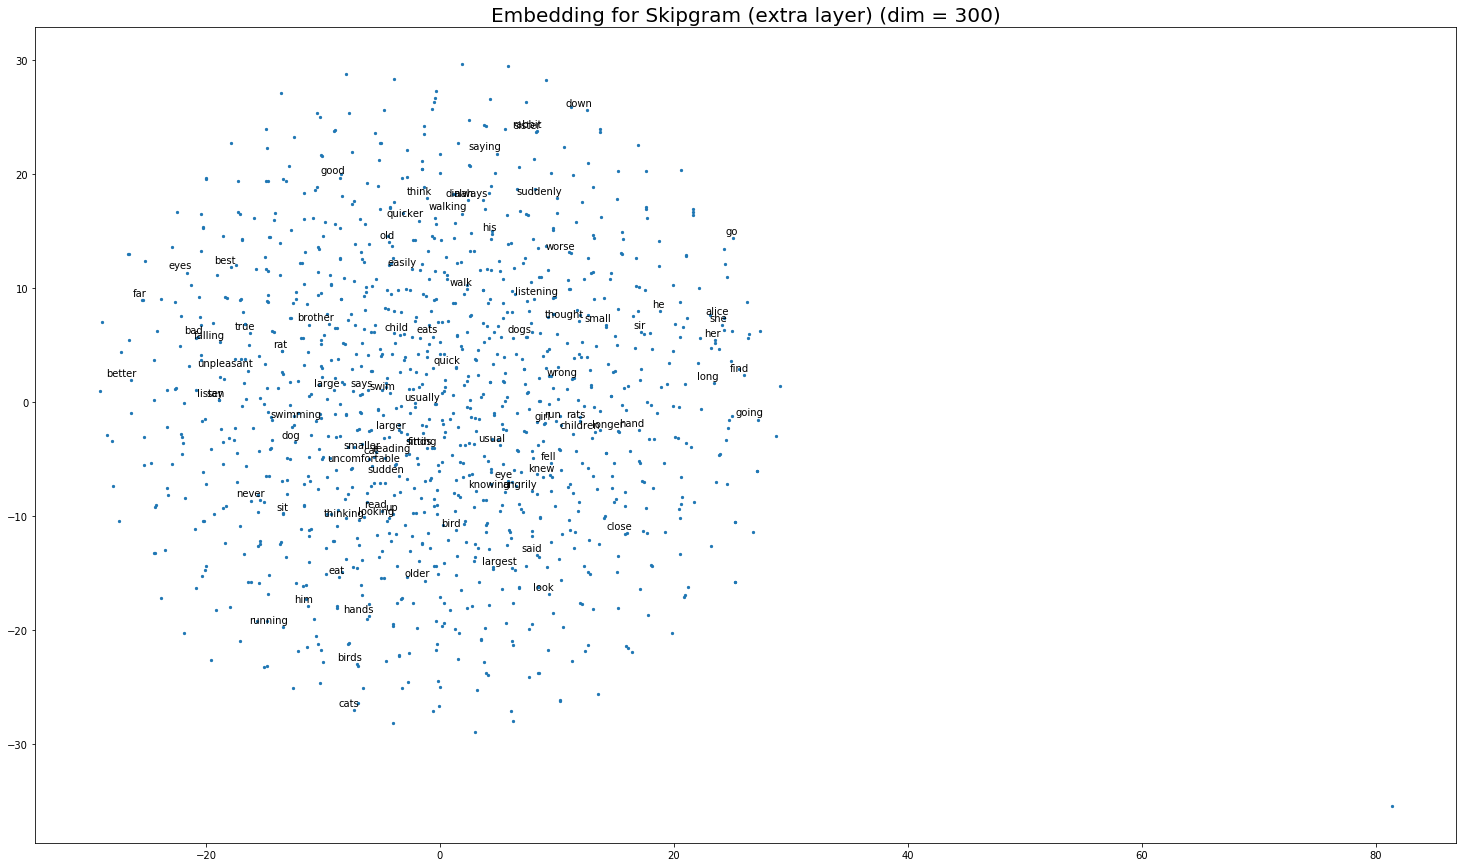

In [412]:
################################################################################
############ 4c. Visualize your results and interpret your results #############
################################################################################
import operator

# Get labels 
plot_labels = getLabels(full_index, True)
filter_labels = getAnalogyWords()

##################################### CBOW #####################################

# Transform data to 2d
weights = cbowWeights[len(cbowWeights) - 1]
tsne = TSNE(n_components=2, verbose=1, random_state = 0)
transformed_weights = tsne.fit_transform(weights)

# Visualize
plot_embedding(transformed_weights, plot_labels, filter_labels, "Embedding for simple CBOW (dim = 300)")


################################### Skipgram ###################################

# Transform data to 2d
weights = skipgramWeights[len(skipgramWeights) - 1]
tsne = TSNE(n_components=2, verbose=1, random_state = 0)
transformed_weights = tsne.fit_transform(weights)

# Visualize
plot_embedding(transformed_weights, plot_labels, filter_labels, "Embedding for simple Skipgram (dim = 300)")


############################## CBOW (extra layer) ##############################

# Transform data to 2d
weights = cbowHiddenLayerWeights[len(cbowHiddenLayerWeights) - 1]
tsne = TSNE(n_components=2, verbose=1, random_state = 0)
transformed_weights = tsne.fit_transform(weights)

# Visualize
plot_embedding(transformed_weights, plot_labels, filter_labels, "Embedding for CBOW (extra layer) (dim = 300)")


############################ Skipgram (extra layer) ############################

# Transform data to 2d
weights = skipgramHiddenLayerWeights[len(skipgramHiddenLayerWeights) - 1]
tsne = TSNE(n_components=2, verbose=1, random_state = 0)
transformed_weights = tsne.fit_transform(weights)

# Visualize
plot_embedding(transformed_weights, plot_labels, filter_labels, "Embedding for Skipgram (extra layer) (dim = 300)")



In [85]:
################################################################################
############# 5. Use the word co-occurence matrix from Question 1 ##############
############# Compare the performance on the analogy task.        ##############
################################################################################
    
nbrs = NearestNeighbors(n_neighbors = 1).fit(wcoMatrix)
analogyResultsWcoMatrix = makeAnalogyOnFile(nbrs, EMBEDDING_TYPE_1, wcoMatrix, full_index)
print("Score for w-w co-ocurrence matrix embedding: %s" % sum(analogyResultsWcoMatrix))

[False] 'sudden suddenly usual usually' - (word, prediction) = (suddenly, met)
[False] 'bad worse good better' - None
[False] 'go going look looking' - (word, prediction) = (going, window)
[False] 'he she his her' - (word, prediction) = (she, going)
[False] 'brother sister his her' - (word, prediction) = (sister, going)
[False] 'listen listening look looking' - (word, prediction) = (listening, cunning)
[False] 'saying said thinking thought' - (word, prediction) = (said, turning)
[False] 'bird birds cat cats' - (word, prediction) = (birds, bird)
[False] 'good better old older' - (word, prediction) = (better, followed)
[False] 'good better quick quicker' - (word, prediction) = (better, followed)
[False] 'large largest good best' - (word, prediction) = (largest, common)
[False] 'falling fell knowing knew' - None
[False] 'walk walking think thinking' - (word, prediction) = (walking, hearthrug)
[False] 'child children cat cats' - (word, prediction) = (children, trial)
[False] 'dog dogs eye 

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1183 samples in 0.038s...
[t-SNE] Computed neighbors for 1183 samples in 2.981s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1183
[t-SNE] Computed conditional probabilities for sample 1183 / 1183
[t-SNE] Mean sigma: 0.014133
[t-SNE] KL divergence after 250 iterations with early exaggeration: 96.736832
[t-SNE] Error after 1000 iterations: 2.001384


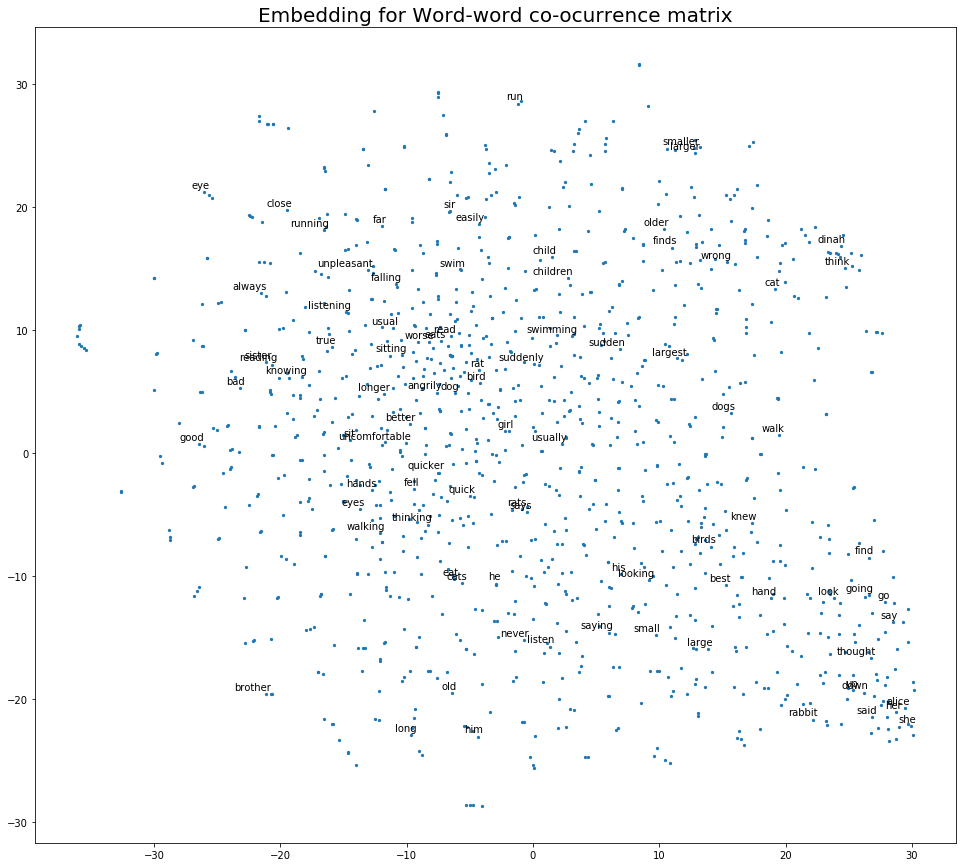

In [413]:
################################################################################
############# 5. Visualization of word co-occurence matrix from Q1 #############
################################################################################

import operator

# Get labels 
plot_labels = getLabels(full_index, True)
filter_labels = getAnalogyWords()


##################################### wwco #####################################

# Transform data to 2d
tsne = TSNE(n_components=2, verbose=1, random_state = 0)
transformed_weights = tsne.fit_transform(wcoMatrix)

# Visualize
plot_embedding(transformed_weights, plot_labels, filter_labels, "Embedding for Word-word co-ocurrence matrix")



Interpretation results of the visualization

Compare the results of the trained word embeddings with the word-word co-occurrence matrix

#### Shapes are similar

#### The from the analogy task, not a significant difference

#### Mention that we measured the time and it decreased

**6. Discuss**

#### What are the main advantages of CBOW and Skipgram?

CBOW:
CBOW does not require a lot of memory. It does not need to have substantial RAM requirements like that of co-occurrence matrix where we actually need to store sometimes three huge matrices.
This CBOW is faster to train and works well with frequent words, this lies in the fact that CBOW is learning to predict the target word based on the context. We can simply "translate" that as maximizing the probability of the target word by looking at the context. 

SKIPGRAM:
The Skip Gram model can capture two semantics for a single word, one for the car company and other for the animal. Skip-Gram is also more efficient with small training data and infrequent words are well presented in contrast with CBOW.

To better understand the difference in lets think of an example We know that CBOW is learning to predict the word based on the context. We can simply "translate" that as maximizing the probability of the target word by looking at the context. This is why CBOW works better with frequent words but not the same happens for rare words. For example, given the context "yesterday was really [...] day" CBOW model will tell us that most probably the word is "beautiful" or "nice", which are quite usually used words. Words like "delightful" on the other hand will get much less attention of the model, because it is designed to predict the most probable word. This word will be smoothed over a lot of examples with more frequent words.

-------------Difference-------------

We know that CBOW is learning to predict the word based on the context. We can simply "translate" that as maximizing the probability of the target word by looking at the context. This is why CBOW works better with frequent words but not the same happens for rare words. For example, given the context "yesterday was really [...] day" CBOW model will tell us that most probably the word is "beautiful" or "nice", which are quite usually used words. Words like "delightful" on the other hand will get much less attention of the model, because it is designed to predict the most probable word. This word will be smoothed over a lot of examples with more frequent words.

On the other hand, the skip-gram is designed to predict the context based on the target word. Given the word "delightful" it must study it and tell us, that there is huge probability, the context is "yesterday was really [...] day", or some other relevant context. With skip-gram the word delightful will not try to compete with word beautiful but instead, delightful+context pairs will be treated as new observations


#### What is the advantage of negative sampling?

Negative sampling tends to work better for frequent words and with low dimensional vectors. For example to optimize performance for appropriate data (frequent words,small data sets) we would use CBOW with negative sampling.

Negative sampling is a way to sample the training data, similar to stochastic gradient descent, but the key is you look for negative training examples. Intuitively, it trains based on sampling places it might have expected a word, but didn't find one, which is faster than training an entire corpus every iteration and makes sense for common words.

Negative sampling is developed based on noise contrastive estimation and randomly samples the words not in the context to distinguish the observed data from the artificially generated random noise.

#### What are the main drawbacks of CBOW and Skipgram?

-CBOW takes the average of the context of a word. For example, Apple can be both a fruit and a company but CBOW takes an average of both the contexts and places it in between a cluster for fruits and companies.
-Training a CBOW from scratch can take forever if not properly optimized <- cant really justify this

Skipgram takes a substantially larger amount of time since rather than averaging the context words, each context word is used as a pairwise training example. That is, in place of one CBOW example such as [predict 'ate' from average('The', 'cat', 'the', 'mouse')], the network is presented with four skip-gram examples [predict 'ate' from 'The'], [predict 'ate' from 'cat'], [predict 'ate' from 'the'], [predict 'ate' from 'mouse']



#### 7. Load pre-trained embeddings on large corpuses (see the pdf file). You only have to consider the word embeddings with an embedding size of 300

In [86]:
################################################################################
############## 7a. Load pre-trained embeddings on large corpuses  ##############
################################################################################

#load pretrained word embeddings of word2vec
path_word2vec = "./GoogleNews-vectors-negative300.bin"
word2vec = KeyedVectors.load_word2vec_format(path_word2vec, binary=True)


In [87]:
#load pretraind word embeddings of Glove

path = "./glove.6B/glove.6B.300d.txt"
path2 = "./glove_converted.txt"

#convert GloVe into word2vec format
gensim.scripts.glove2word2vec.get_glove_info(path)
gensim.scripts.glove2word2vec.glove2word2vec(path, "glove_converted.txt")

glove = KeyedVectors.load_word2vec_format(path2, binary=False)


In [331]:
################################################################################
############# 7b. Performance on the analogy task Google-word2vec  #############
################################################################################

analogyResults = makeAnalogyOnFile(neighbors = None, embeddingType = EMBEDDING_TYPE_2, matrix = None, index = word2vec)

print("\nCount for GoogleNews embedding: %s" % (sum(analogyResults)))
print("Score for GoogleNews embedding: %s" % (sum(analogyResults)/len(analogyResults)))


[False] 'happy unhappy pleasant unpleasant' - (word, prediction) = (unhappy, happy)
[False] 'sudden suddenly usual usually' - (word, prediction) = (suddenly, sudden)
[False] 'bad worse good better' - (word, prediction) = (worse, better)
[False] 'go going look looking' - (word, prediction) = (going, go)
[True] 'he she his her' - (word, prediction) = (she, she)
[True] 'brother sister his her' - (word, prediction) = (sister, sister)
[False] 'listen listening look looking' - (word, prediction) = (listening, listen)
[False] 'saying said thinking thought' - (word, prediction) = (said, saying)
[True] 'bird birds cat cats' - (word, prediction) = (birds, birds)
[False] 'good better old older' - (word, prediction) = (better, good)
[True] 'good better quick quicker' - (word, prediction) = (better, better)
[False] 'large largest good best' - (word, prediction) = (largest, large)
[False] 'happy unhappy comfortable uncomfortable' - (word, prediction) = (unhappy, happy)
[False] 'falling fell knowing 

In [221]:
################################################################################
############## 7b. Performance on the analogy task Glove-word2vec ##############
################################################################################

analogyResults = makeAnalogyOnFile(neighbors = None, embeddingType = EMBEDDING_TYPE_2, matrix = None, index = glove)

print("\nCount for Glove embedding: %s" % (sum(analogyResults)))
print("Score for Glove embedding: %s" % (sum(analogyResults)/len(analogyResults)))



[False] 'happy unhappy pleasant unpleasant' - (word, prediction) = (unhappy, enraged)
[False] 'sudden suddenly usual usually' - (word, prediction) = (suddenly, sudden)
[False] 'bad worse good better' - (word, prediction) = (worse, 109.43)
[False] 'go going look looking' - (word, prediction) = (going, went)
[True] 'he she his her' - (word, prediction) = (she, she)
[True] 'brother sister his her' - (word, prediction) = (sister, sister)
[False] 'listen listening look looking' - (word, prediction) = (listening, listen)
[False] 'saying said thinking thought' - (word, prediction) = (said, saying)
[False] 'bird birds cat cats' - (word, prediction) = (birds, bird)
[False] 'good better old older' - (word, prediction) = (better, importantly)
[False] 'good better quick quicker' - (word, prediction) = (better, happier)
[False] 'large largest good best' - (word, prediction) = (largest, large)
[False] 'happy unhappy comfortable uncomfortable' - (word, prediction) = (unhappy, cursed)
[False] 'falling

In [176]:
# Filtering only our vocabulary, otherwise it take way too long (never ending)

# Filtering only our vocabulary, otherwise it take way too long (never ending)
cT = 0
cF = 0
myGoogleIndex = dict()
myGoogleEmbeddings = []

counter = 0
for k, v in full_index.items():
    try: 
        value = word2vec.word_vec(k)
        myGoogleIndex[k] = counter
        myGoogleEmbeddings.append(value)
        cT += 1
        counter += 1
    except KeyError:
        cF +=1

myGoogleEmbeddings = np.asarray(myGoogleEmbeddings)

print("Total of words included in Google index:", cT)
print("Total of words not included in Google index:", cF)


cT = 0
cF = 0
myGloveIndex = dict()
myGloveEmbeddings = []

counter = 0
for k, v in full_index.items():
    try: 
        value = glove.word_vec(k)
        myGloveIndex[k] = counter
        myGloveEmbeddings.append(value)
        cT += 1
        counter += 1
    except KeyError:
        cF +=1

myGloveEmbeddings = np.asarray(myGloveEmbeddings)


print("Total of words included in Glove index:", cT)
print("Total of words not included in Glove index:", cF)

Total of words included in Google index: 1157
Total of words not included in Google index: 25
Total of words included in Glove index: 1173
Total of words not included in Glove index: 9


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1157 samples in 0.015s...
[t-SNE] Computed neighbors for 1157 samples in 0.700s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1157
[t-SNE] Computed conditional probabilities for sample 1157 / 1157
[t-SNE] Mean sigma: 0.782791
[t-SNE] KL divergence after 250 iterations with early exaggeration: 111.731049
[t-SNE] Error after 1000 iterations: 1.915029


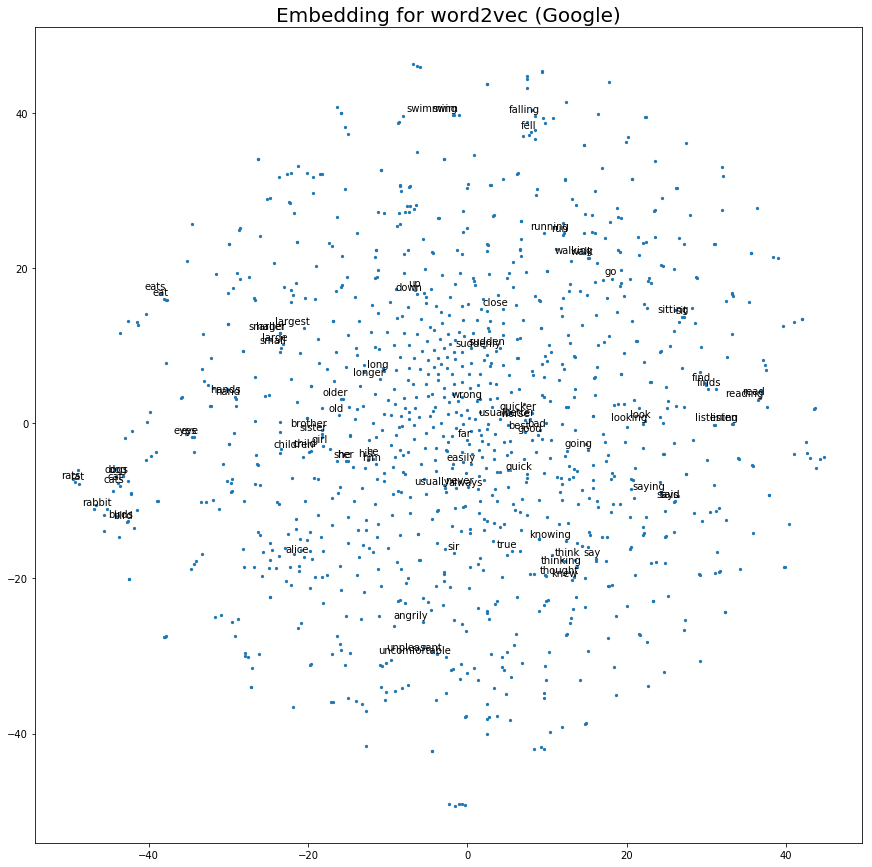

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1173 samples in 0.011s...
[t-SNE] Computed neighbors for 1173 samples in 0.766s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1173
[t-SNE] Computed conditional probabilities for sample 1173 / 1173
[t-SNE] Mean sigma: 1.710005
[t-SNE] KL divergence after 250 iterations with early exaggeration: 95.954338
[t-SNE] Error after 1000 iterations: 1.837828


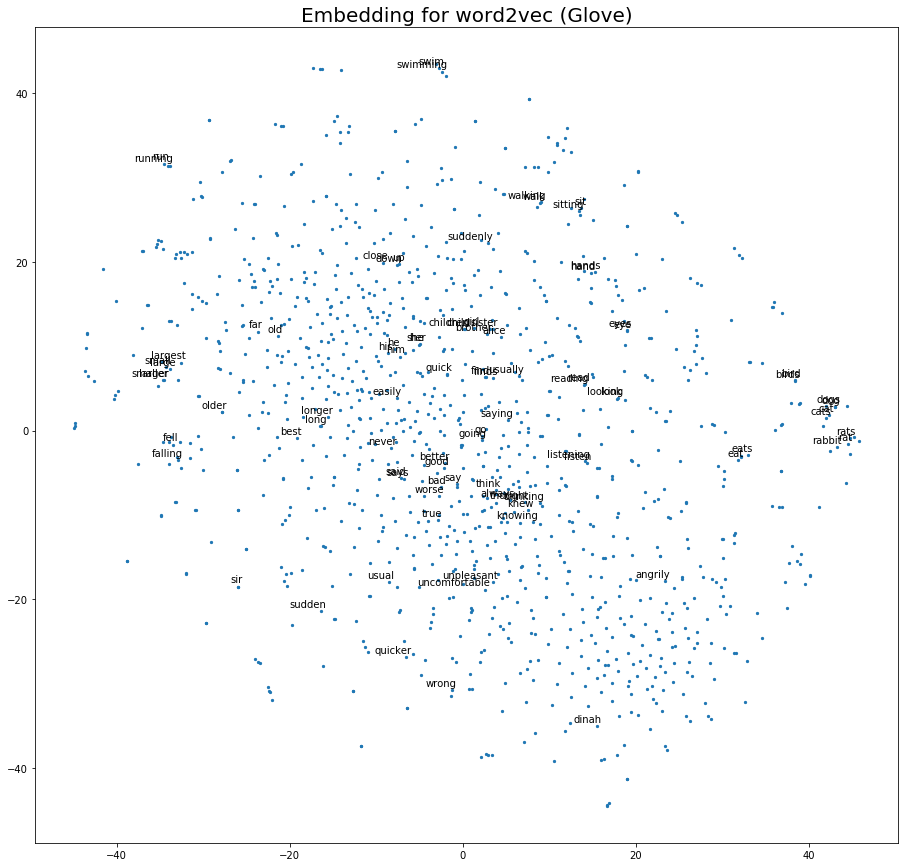

In [414]:
################################################################################
###################### 7. Visualize embeddings (word2vec) ######################
################################################################################

################################## GoogleNews ##################################
import operator

plot_labels = getLabels(myGoogleIndex)
filter_labels = getAnalogyWords()

#Transform data to 2d
tsne = TSNE(n_components=2, verbose=1, random_state = 0)
transformed_weights = tsne.fit_transform(myGoogleEmbeddings)

# Visualize
plot_embedding(transformed_weights, plot_labels, filter_labels, "Embedding for word2vec (Google)")

#################################### Glove ####################################

plot_labels = getLabels(myGloveIndex)


#Transform data to 2d
tsne = TSNE(n_components=2, verbose=1, random_state = 0)
transformed_weights = tsne.fit_transform(myGloveEmbeddings)

# Visualize
plot_embedding(transformed_weights, plot_labels, filter_labels, "Embedding for word2vec (Glove)")



Comparison performance with your own trained word embeddings

In [ ]:
# Show up that the embeddings are similar (in shape)

# The difference in performance (analogy task) is due to the neighbor computation

# The domain contains higher values because of the space the words belong to (broad vocabulary)

